In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def plot_series(time, series, format="-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi), 
                  1/np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period) / period
  return amplitude * seasonal_pattern(season_time) 

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time,0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1,drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 88ms/step - loss: 73.6219 - mae: 74.1211
Epoch 2/100
8/8 [==============================] - 1s 74ms/step - loss: 72.6254 - mae: 73.1244
Epoch 3/100
8/8 [==============================] - 1s 73ms/step - loss: 71.9014 - mae: 72.4006
Epoch 4/100
8/8 [==============================] - 1s 74ms/step - loss: 70.2161 - mae: 70.7153
Epoch 5/100
8/8 [==============================] - 1s 71ms/step - loss: 69.7407 - mae: 70.2399
Epoch 6/100
8/8 [==============================] - 1s 72ms/step - loss: 67.1022 - mae: 67.6009
Epoch 7/100
8/8 [==============================] - 1s 72ms/step - loss: 64.5805 - mae: 65.0794
Epoch 8/100
8/8 [==============================] - 1s 73ms/step - loss: 62.2406 - mae: 62.7393
Epoch 9/100
8/8 [==============================] - 1s 74ms/step - loss: 59.6863 - mae: 60.1848
Epoch 10/100
8/8 [==============================] - 1s 73ms/step - loss: 56.2421 - mae: 56.7407
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

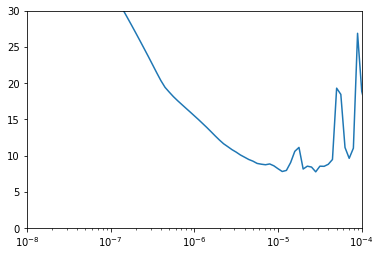

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 23ms/step - loss: 34.8052 - mae: 35.3014
Epoch 2/500
31/31 [==============================] - 1s 25ms/step - loss: 11.9285 - mae: 12.4171
Epoch 3/500
31/31 [==============================] - 1s 26ms/step - loss: 10.6705 - mae: 11.1569
Epoch 4/500
31/31 [==============================] - 1s 26ms/step - loss: 9.3784 - mae: 9.8630
Epoch 5/500
31/31 [==============================] - 1s 26ms/step - loss: 8.6970 - mae: 9.1821
Epoch 6/500
31/31 [==============================] - 1s 26ms/step - loss: 9.2949 - mae: 9.7805
Epoch 7/500
31/31 [==============================] - 1s 26ms/step - loss: 9.6751 - mae: 10.1616
Epoch 8/500
31/31 [==============================] - 1s 24ms/step - loss: 8.5855 - mae: 9.0699
Epoch 9/500
31/31 [==============================] - 1s 26ms/step - loss: 8.9802 - mae: 9.4654
Epoch 10/500
31/31 [==============================] - 1s 26ms/step - loss: 8.1859 - mae: 8.6685
Epoch 11/500
31/31 [======================

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [19]:
series.shape

(1461,)

In [20]:
series[..., np.newaxis].shape

(1461, 1)

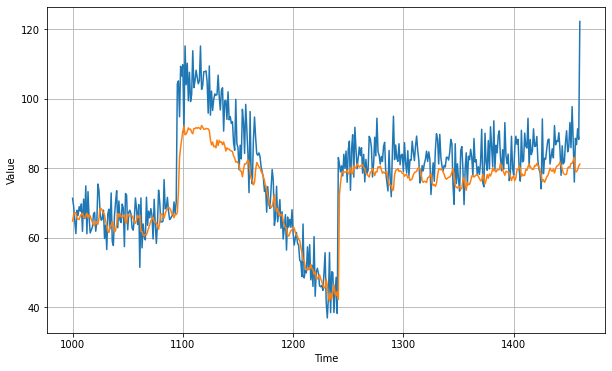

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.4955573

<Figure size 432x288 with 0 Axes>

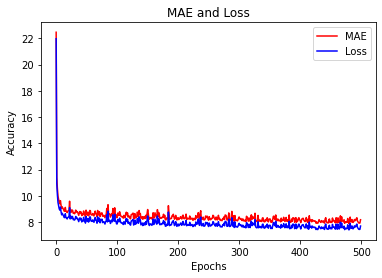

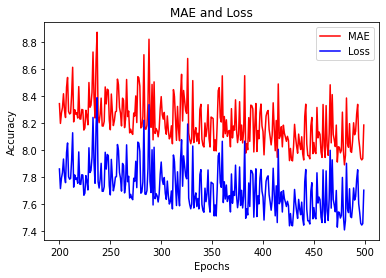

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()